# Q Factor

## Reformat Data

**Import the two data tables.**
- Table of all the relevant publications with their associated authors, year, citations, etc.-
- List of all the SCOPUS_ID for authors of interest


In [1]:
from os import write

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import shapiro, probplot

# Load the data from Excel files
df_all_works_raw = pd.read_excel("Combined_Scopus_Published_Works.xlsx")
df_author_IDs_raw = pd.read_excel("Scopus_IDs.xlsx")



Since the data were obtained from SCOPUS containing >100,000 entries, we will need to perform multiple steps of quality control to clean the data prior to its use.

The data were collected in multiple batches from SCOPUS, so it is likely there are duplicate rows. 
1. Remove duplicate entries that in both of these data sets.

In [2]:
# Remove duplicate rows in each dataframe
df_all_works = df_all_works_raw.drop_duplicates()
df_author_IDs = df_author_IDs_raw.drop_duplicates()

print(f"In the raw data for publications, there are {df_all_works_raw.shape[0]} publication entries, and after removing duplicates, we are left with  {df_all_works.shape[0]} publication entries.")

print(f"\nIn the raw data for authors, there are {df_author_IDs_raw.shape[0]} authors, and after removing duplicates, we are left with {df_author_IDs.shape[0]} authors.")

# View overview of the large publication dataset
print("\nHere is a brief overview of some of the columns in our publication data:\n",df_all_works.describe())

In the raw data for publications, there are 104885 publication entries, and after removing duplicates, we are left with  73091 publication entries.

In the raw data for authors, there are 1303 authors, and after removing duplicates, we are left with 1280 authors.

Here is a brief overview of some of the columns in our publication data:
              Authors               Author full names  Author(s) ID    Title  \
count          73088                           73089         73074    73074   
unique         63657                           64328         63063    67400   
top     Pollock B.E.  Pollock, Bruce E. (7103208372)    7103208372  Preface   
freq             101                              91           101       52   

         Year                                       Source title  Volume  \
count   73075                                              73069   70187   
unique    110                                               4539    1090   
top      2021  International Journal 

Create a new data table which takes all the authors' Scopus IDs, and lists all the publications and associated information for which they are listed.

In [3]:
# Convert SCOPUS_ID (i.e., author ID) from integer to string, needed for merge
df_author_IDs['SCOPUS_ID'] = df_author_IDs['SCOPUS_ID'].astype(str)

# Copy column that contains author IDs into a new column called 'All_Authors'
df_all_works['All_Authors'] = df_all_works['Author(s) ID']

# Split the 'Author(s) ID' column into separate rows in the all_works dataframe
# This will allow us to use merge to match the list of author IDs we have to their associated published works
df_all_works = df_all_works.assign(**{'Author(s) ID': df_all_works['Author(s) ID'].str.split('; ')}).explode('Author(s) ID')

# Merge the datasets on SCOPUS_ID and Author_ID to make a merged dataset with each publication listed for each author
merged_data = pd.merge(df_author_IDs, df_all_works, left_on='SCOPUS_ID', right_on='Author(s) ID', how='inner')

# Filter desired columns
desired_columns = ['SCOPUS_ID','Author_Name','Author full names','Title','Year','Source title','Cited by','DOI','Link','Authors with affiliations','Publisher','PubMed ID','Document Type','All_Authors'
                  ]
merged_data = merged_data[desired_columns]

# Convert SCOPUS ID back to integer
merged_data['SCOPUS_ID'] = merged_data['SCOPUS_ID'].astype('Int64')

#Filter desired columns for output and create Excel file
write_to_excel = True
if write_to_excel: 
    merged_data.to_excel('merged_dataframe.xlsx', index=False)

C:\Users\hgupt\AppData\Local\Temp\ipykernel_30272\1598163648.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_author_IDs['SCOPUS_ID'] = df_author_IDs['SCOPUS_ID'].astype(str)
C:\Users\hgupt\AppData\Local\Temp\ipykernel_30272\1598163648.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_works['All_Authors'] = df_all_works['Author(s) ID']
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the co

## Examine data characteristics

First, we will: 
- Determine total number of authors and publications
- Visualize publications per year

Number of distinct authors: 1263.
Number of distinct publications: 64747.


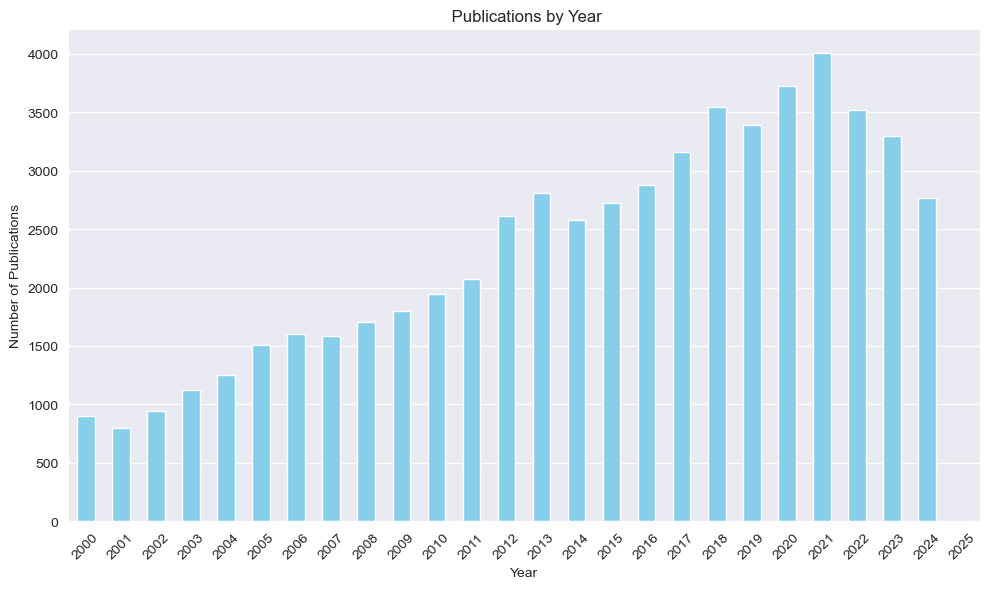

In [4]:
# Calculate number of unique authors and publications
print(f"Number of distinct authors: {merged_data['SCOPUS_ID'].nunique()}."
      f"\nNumber of distinct publications: {merged_data['Title'].nunique()}."
      )

# Filter and group data to count unique publications per year from {year} onwards
publications_per_year = (merged_data[merged_data['Year'] >= 2000]
    .groupby('Year')['Title']
    .nunique().reset_index(name='Number of Publications')
)

# Plotting publications per year
publications_per_year.plot(kind='bar', x='Year', y='Number of Publications', figsize=(10, 6), color='skyblue', legend=False)
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.title(' Publications by Year')
plt.xticks(rotation=45)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

- Confirm that the data in citations column are integers and without missing values.
- Calculate number of citations per author
- Calculate number of publications per author

In [5]:
### Confirm the citations column has values that are all integers
all_integers = merged_data['Cited by'].apply(lambda x: isinstance(x, int))
print(f"All values in citation column are integers: {all_integers.all()}")

# Count the number of missing (NaN) and empty values
missing_values = merged_data['Cited by'].isna().sum() + (merged_data['Cited by'] == '').sum()
print(f"Number of missing or empty values in citation column: {missing_values}")

### Calculate the average number of citations per author
citations_per_author = merged_data.groupby('SCOPUS_ID')['Cited by'].mean().mean()
print(f"Average number of citations per author: {citations_per_author:.8f}\n")

### Count the number of publications per SCOPUS_ID (author)
publications_per_author = merged_data['SCOPUS_ID'].value_counts().reset_index()
publications_per_author.columns = ['SCOPUS_ID', 'Number_of_Publications']

### Summary Statistics related to publications_per_author
pubs_info = publications_per_author['Number_of_Publications']

summary_stats = {
    'Total Number of Authors': len(publications_per_author),
    'Average publications per author': pubs_info.mean(),
    'Max': pubs_info.max(),
    'Min': pubs_info.min(),
    'SD': pubs_info.std(),
    'Median': pubs_info.median(),
}

# Print the summary statistics
for key, value in summary_stats.items():
    print(f"{key}: {value}")

# Saving statistics to Excel if desired
write_to_excel = False
if write_to_excel:
    with pd.ExcelWriter('publications_per_author.xlsx') as writer:
        publications_per_author.to_excel(writer, sheet_name='Publication Counts', index=False)
        summary_stats_df = pd.DataFrame(list(summary_stats.items()), columns=['Statistic', 'Value'])
        summary_stats_df.to_excel(writer, sheet_name='Summary Statistics', index=False)


All values in citation column are integers: True
Number of missing or empty values in citation column: 0
Average number of citations per author: 37.82047526

Total Number of Authors: 1263
Average publications per author: 99.55898653998416
Max: 1139
Min: 1
SD: 113.26881114434329
Median: 62.0


## Calculate Q factor

$$
Q_{i} = e^{\frac{1}{N}\sum_{a=1}^{N}\log_{}(c_{5,ia})}-\mu_{p} 
$$

We will calculate Q-factor with the following conditions:
- Publications from 2020 onwards will be excluded to allow for at least 5-year citation data
- For now, we will ignore the constant, $\mu_{p}$, due to the authors of interest being in the same field - radiation oncology
- Currently, a publication with 1 citation is weighted as equally as a publication with 0 citations

In [6]:
# Step 1: Filter the merged_data to include only years 2019 and before
filtered_data = merged_data[merged_data['Year'] <= 2019].copy()
# Convert to numeric and drop NaNs
filtered_data['Cited by']= pd.to_numeric(filtered_data['Cited by'], errors='coerce').dropna()
# Convert zeroes with ones to handle log(0)
filtered_data['Cited by']= filtered_data['Cited by'].replace(0, 1)
print(f"Total authors is {filtered_data['SCOPUS_ID'].nunique()}")

# Step 2: Define function to calculate q_factor for each author
def calculate_q_factor(group):
    total_publications = len(group)
    sum_log_citations = np.sum(np.log10(group['Cited by']))
    if total_publications == 0:
        return pd.Series([0, 0], index=['Q_factor','total_publications']) 
    else:
        q_factor = np.exp(sum_log_citations / total_publications)
    return pd.Series([q_factor,total_publications], index=['Q_factor','total_publications'])

# Step 3: Group by SCOPUS_ID and apply the calculate_q_factor function
q_factors = filtered_data.groupby('SCOPUS_ID').apply(calculate_q_factor,include_groups=False).reset_index()

# Step 4: Add author names to q factor dataframe 
q_factors = q_factors.merge(filtered_data.groupby('SCOPUS_ID')['Author_Name'].first().reset_index(), on='SCOPUS_ID')

# Reorder columns
q_factors = q_factors[['SCOPUS_ID', 'Author_Name', 'Q_factor', 'total_publications']]

# Write q_factors to a file
write_to_excel = True
if write_to_excel:
    with pd.ExcelWriter('Q_factors.xlsx') as writer:
        q_factors.to_excel(writer, sheet_name='Q_factors', index=False)
        filtered_data.to_excel(writer, sheet_name='2019_data', index=False)

Total authors is 1251


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

C:\Users\hgupt\anaconda3\Lib\site-packages\xlsxwriter\worksheet.py:1261: UserWarning: Ignoring URL 'https://www.scopus.com/inward/record.uri?eid=2-s2.0-85042256332&doi=10.1088%2f1361-6560%2faaaa15&partnerID=40&md5=51c20ae0bb4e7a4746c471e5de47d932' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  warn(
C:\Users\hgupt\anaconda3\Lib\site-packages\xlsxwriter\worksheet.py:1261: UserWarning: Ignoring URL 'https://www.scopus.com/inward/record.uri?eid=2-s2.0-85126610982&partnerID=40&md5=eea53f729add1d0e477f3220547b267a' since it exceeds Excel's limit of 65,530 URLS per worksheet.
  warn(
C:\Users\hgupt\anaconda3\Lib\site-packages\xlsxwriter\worksheet.py:1261: UserW

### Check Q-factor distribution

Now, we have generated the q_factors. We will next check their distribution with:
- Histogram
- Shapiro-Wilk test
- Q-Q plot

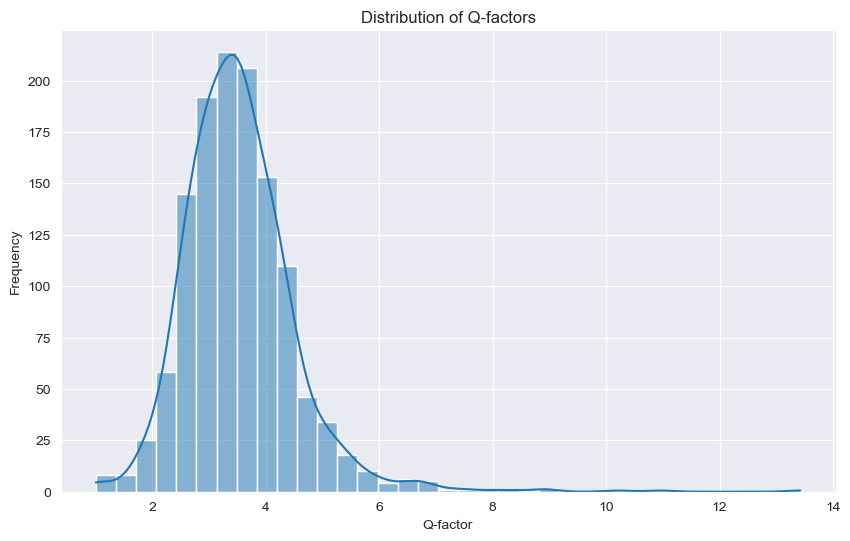

Shapiro-Wilk Test: Statistics=0.884, p=0.000
Sample does not look Gaussian (reject H0)


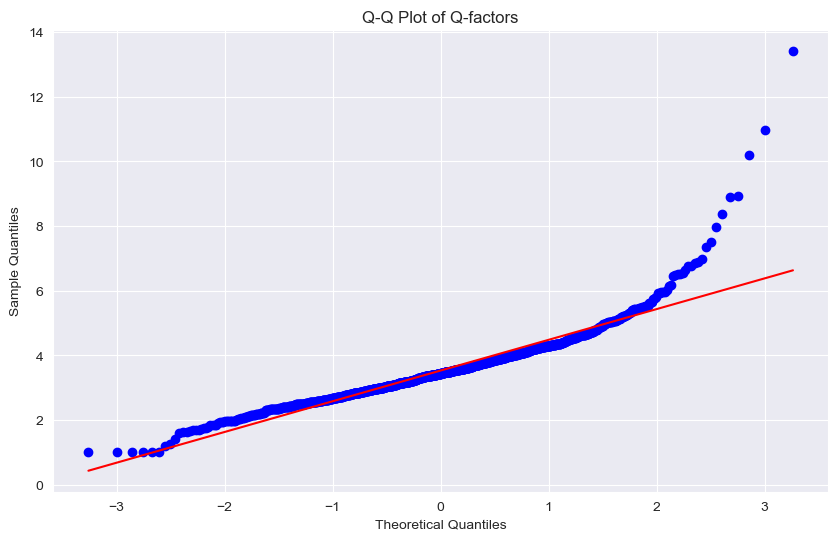

In [7]:
# Plot histogram of q_factors
plt.figure(figsize=(10, 6))
sns.histplot(q_factors['Q_factor'], kde=True, bins=int(np.sqrt(len(q_factors['Q_factor']))))
plt.title('Distribution of Q-factors')
plt.xlabel('Q-factor')
plt.ylabel('Frequency')
plt.show()

# Shapiro-Wilk Test
stat, p = shapiro(q_factors['Q_factor'])
print('Shapiro-Wilk Test: Statistics=%.3f, p=%.3f' % (stat, p))
# Interpret the result
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

# Q-Q plot
plt.figure(figsize=(10, 6))
probplot(q_factors['Q_factor'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Q-factors')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

Summary statistics for the Q factor

Descriptive statistics for Q_factor:
                   Statistic      Value
0                       Mean   3.533571
1                        Std   1.009951
2                     Median   3.438546
3                        Min   1.000000
4                        Max  13.422040
5       Q1 (25th percentile)   2.912636
6       Q3 (75th percentile)   4.003822
7  IQR (Interquartile Range)   1.091186


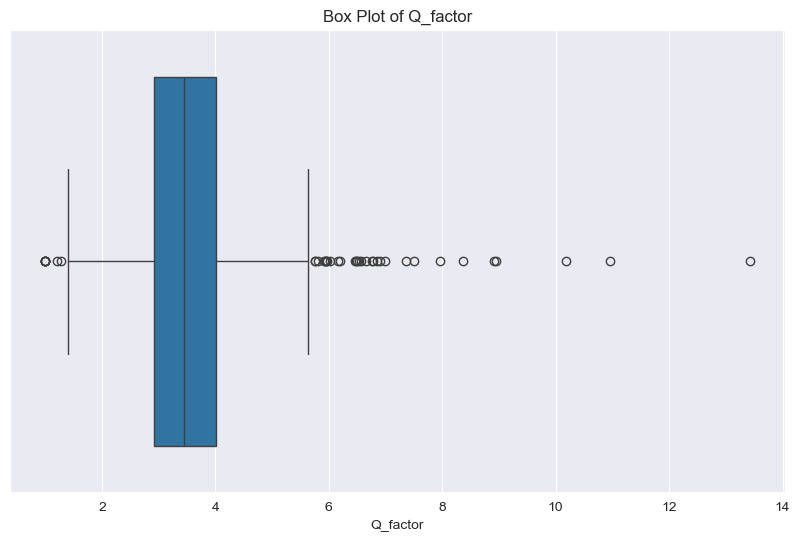

In [8]:
# Function to generate descriptive statistics and extended box plot
def generate_statistics_and_boxplot(data, column_name):
    # Extract values from the column
    values = data[column_name]
    
    # Calculate descriptive statistics
    column_mean = values.mean()
    column_std = values.std()
    column_median = values.median()
    column_min = values.min()
    column_max = values.max()
    column_q1 = values.quantile(0.25)
    column_q3 = values.quantile(0.75)
    column_iqr = column_q3 - column_q1

    # Create a descriptive statistics summary DataFrame
    column_summary = pd.DataFrame({
        'Statistic': ['Mean', 'Std', 'Median', 'Min', 'Max', 'Q1 (25th percentile)', 'Q3 (75th percentile)', 'IQR (Interquartile Range)'],
        'Value': [column_mean, column_std, column_median, column_min, column_max, column_q1, column_q3, column_iqr]
    })

    print(f"Descriptive statistics for {column_name}:")
    print(column_summary)

    # Create a box plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=values, whis=1.5)
    plt.title(f'Box Plot of {column_name}')
    plt.xlabel(column_name)
    plt.show()

generate_statistics_and_boxplot(q_factors, 'Q_factor')

3 random scientists with different Q-factors were selected. Each of their publications was graphed as a function of years since their first publication and total number of citations for that publication. 

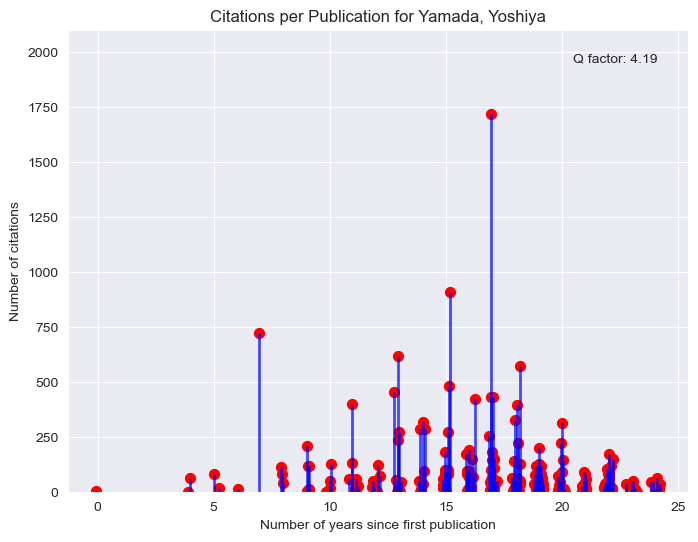

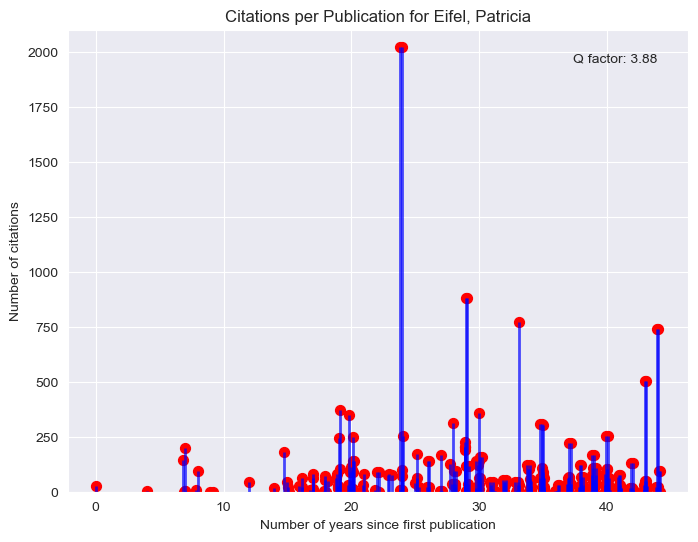

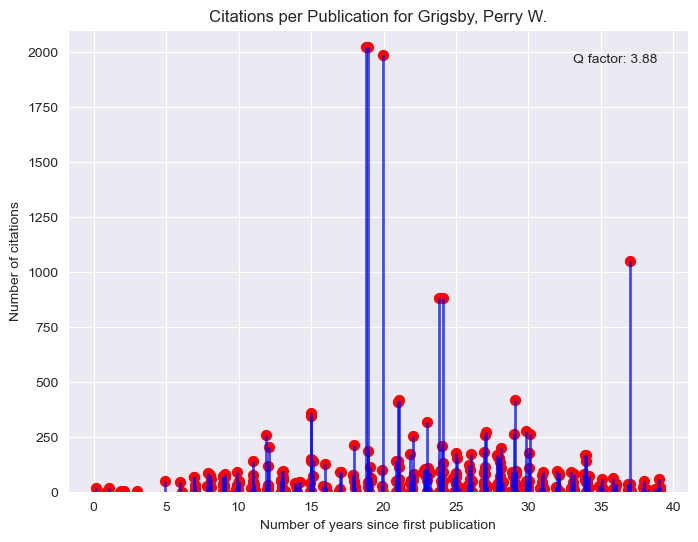

In [9]:
# Filter scientists with at least 100 publications
scientists_with_100_publications = q_factors[q_factors['total_publications'] >= 100]

# Select three random scientists with different Q-factors among those with at least 100 publications
random_scientists = scientists_with_100_publications.sample(n=3, random_state=2)

# Function to add random jitter to the x-values
np.random.seed(0)  # For reproducibility
def add_jitter(values, jitter_amount=0.1):
    return values + np.random.normal(0, jitter_amount, size=values.shape)

# Generate vertical lollipop plots
for idx, (scopus_id, author_name, q_factor, _) in random_scientists.iterrows():
    author_data = filtered_data[filtered_data['SCOPUS_ID'] == scopus_id].copy()
    author_data['Years Since First Publication'] = author_data['Year'] - author_data['Year'].min()

    # Add jitter to 'Years Since First Publication'
    jittered_x = add_jitter(author_data['Years Since First Publication'].values)

    plt.figure(figsize=(8, 6))
    # Plot the stick
    plt.vlines(x=jittered_x, ymin=0, ymax=author_data['Cited by'], color='blue',
               alpha=0.7, linewidth=2)
    # Plot the dot
    plt.scatter(x=jittered_x, y=author_data['Cited by'], color='red', alpha=1,
                s=50)
    plt.ylim(0, 2100)  # Set max y-value to 2000
    plt.xlabel("Number of years since first publication")
    plt.ylabel('Number of citations')
    plt.title(f'Citations per Publication for {author_name}')
    plt.text(0.95, 0.95, f'Q factor: {q_factor:.2f}', ha='right', va='top', transform=plt.gca().transAxes)
    plt.show()

**It is noticed that the authors with the highest q-factor have the fewest number of publications as seen below**

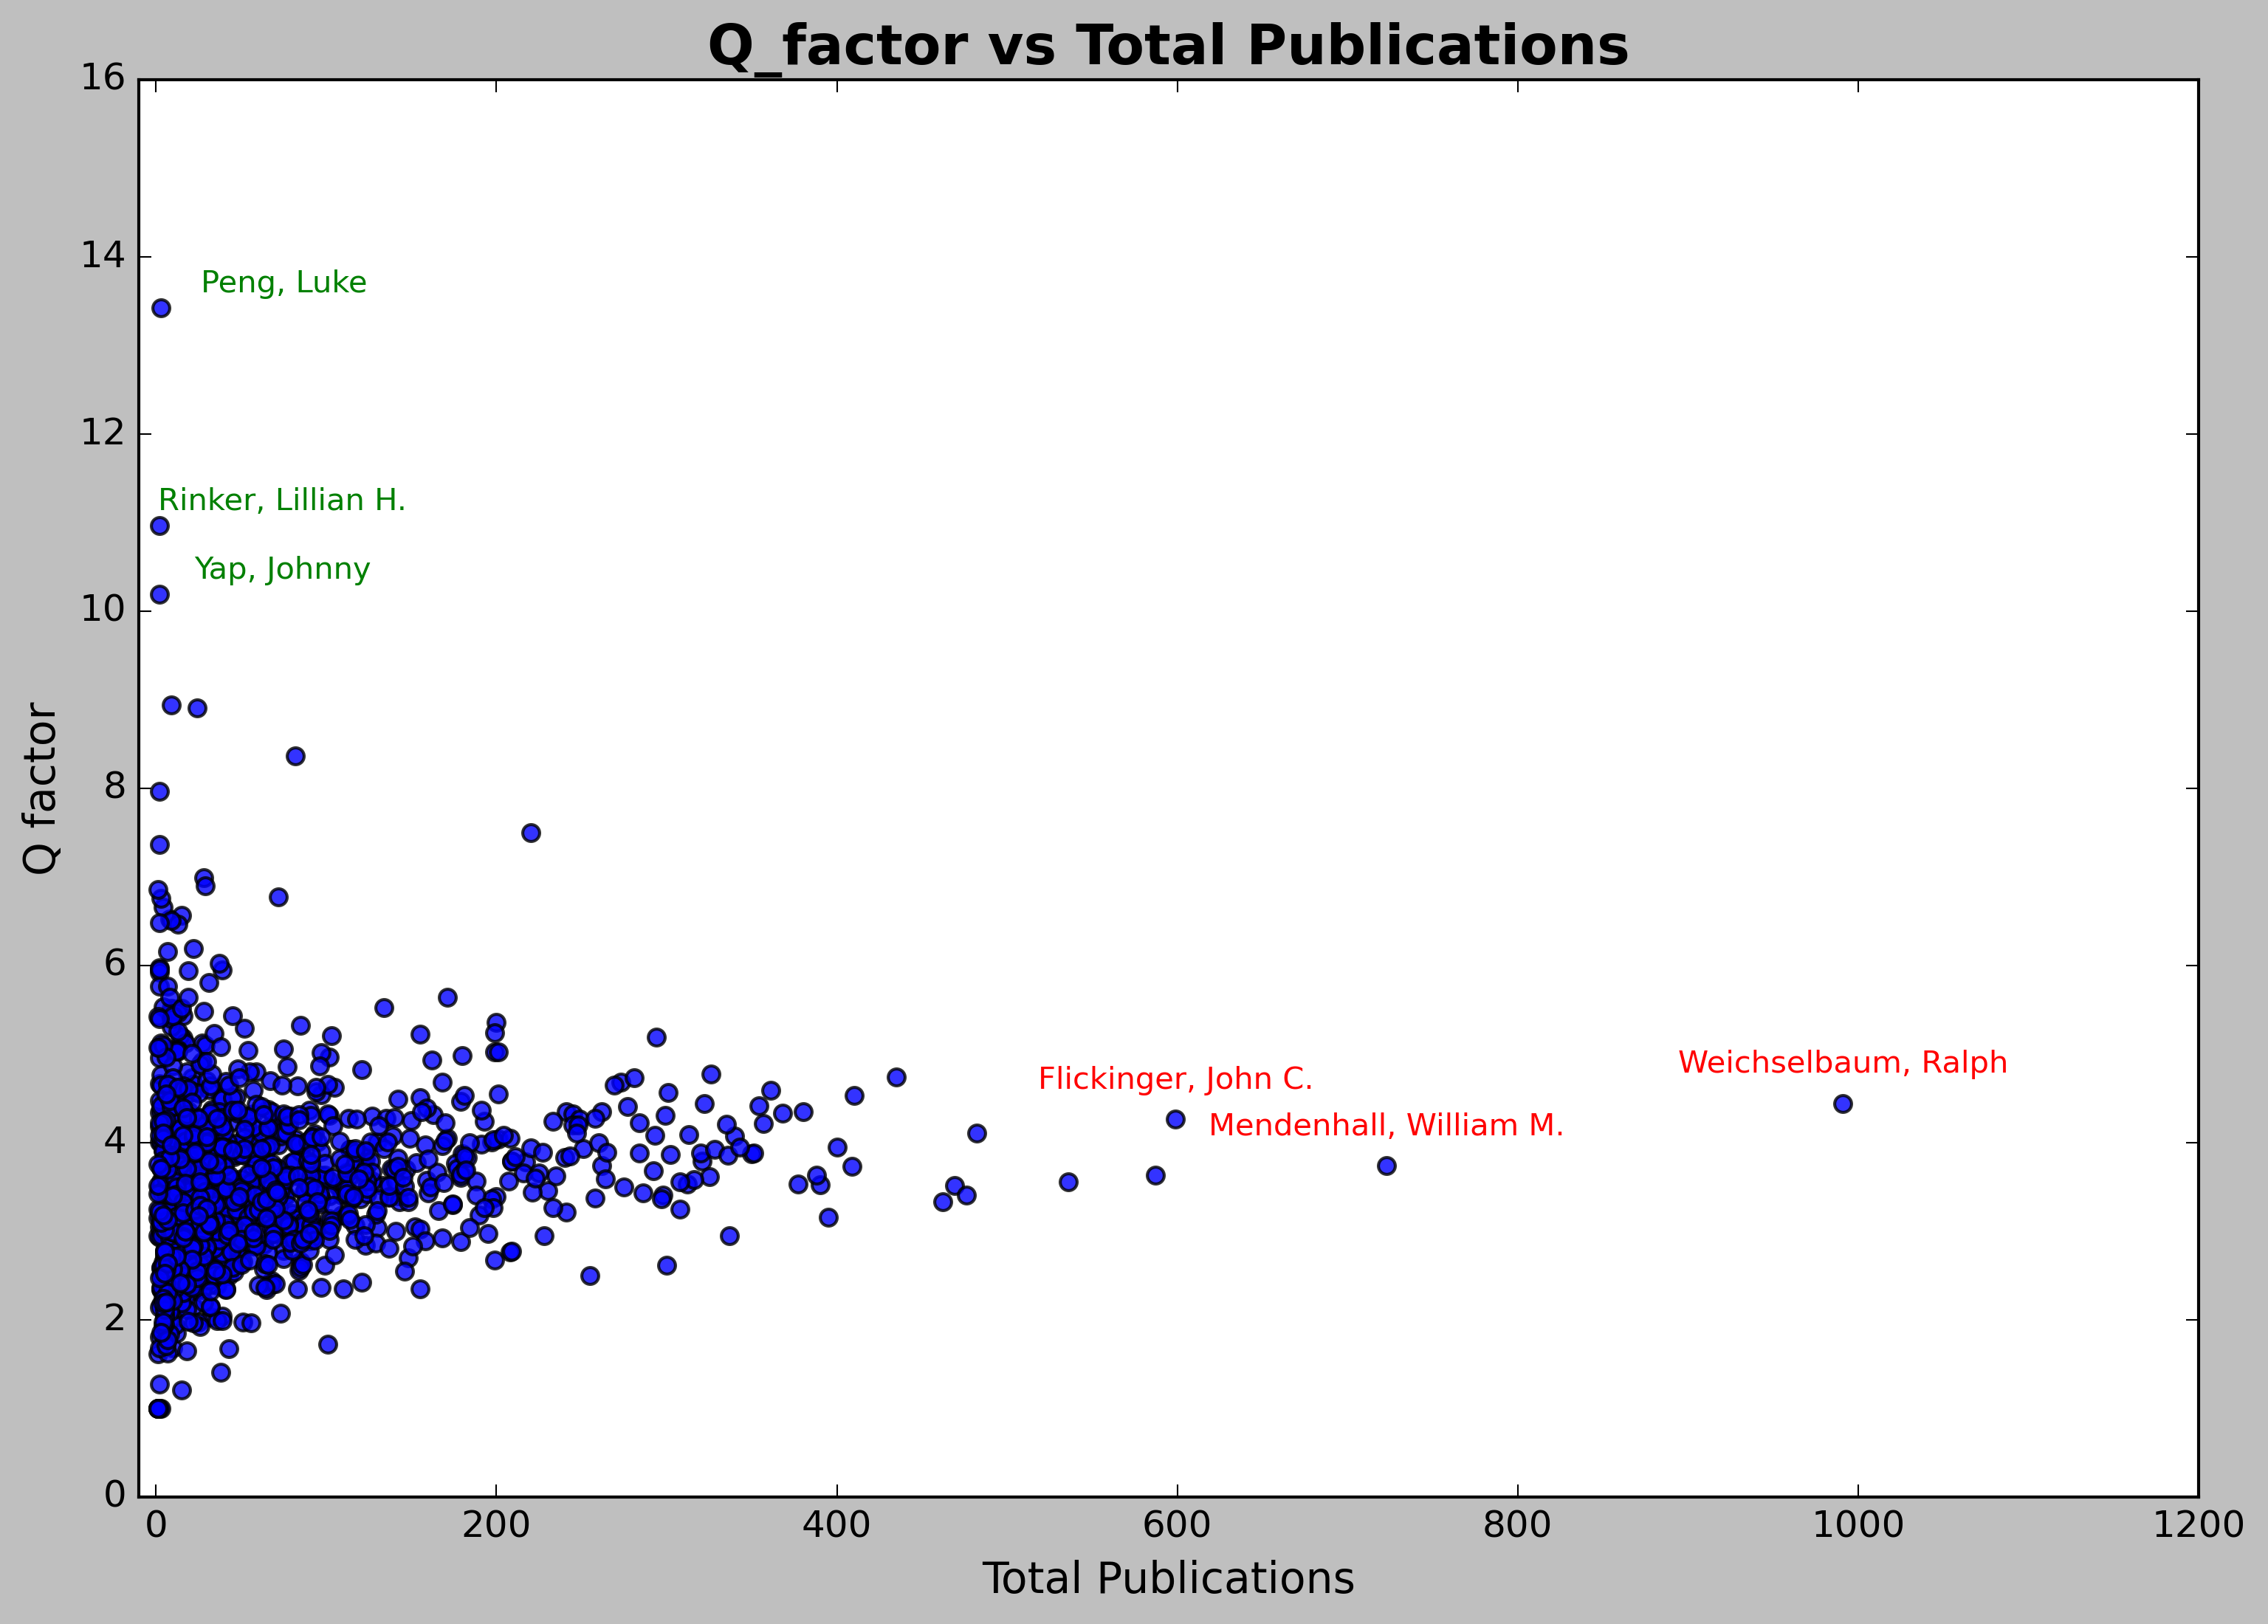

In [10]:

# Identify the top 3 highest total publications and Q factors
top_total_pubs = q_factors.nlargest(3, 'total_publications')
top_q_factors = q_factors.nlargest(3, 'Q_factor')

# Create the scatter plot
plt.style.use('classic')
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
scatter = ax.scatter(q_factors['total_publications'], q_factors['Q_factor'], alpha=0.8, edgecolors='black', s=30, c='blue')

# Adding titles and labels
ax.set_title('Q_factor vs Total Publications', fontsize=18, weight='bold')
ax.set_xlabel('Total Publications', fontsize=14)
ax.set_ylabel('Q factor', fontsize=14)

# Set x-axis to start at 0 and adjust tick parameters
ax.set_xlim(left=-10)
ax.tick_params(axis='both', which='major', labelsize=12)

# Add annotations for highest total publications
for index, row in top_total_pubs.iterrows():
    ax.annotate(row['Author_Name'],
                (row['total_publications'], row['Q_factor']),
                textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='red')

# Add annotations for highest Q factors
for index, row in top_q_factors.iterrows():
    ax.annotate(row['Author_Name'],
                (row['total_publications'], row['Q_factor']),
                textcoords="offset points", xytext=(40, 5), ha='center', fontsize=10, color='green')
    
# Adding a grid
#ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Saving the plot to a file
plt.savefig('Q_factor_vs_publications.png', bbox_inches='tight')

plt.show()